## I/ Dùng Chung Tham Số Của Hàm SigMoid Cho Cả 3 Loại Thực Phẩm
Ta thấy việc dùng chung tham số của hàm SigMoid cho 3 loại thực phẩm sẽ không hiệu quả vì kể cả khi cùng chứa 1 lượng tinh bột, thực phẩm giàu chất sơ và chất béo sẽ làm chậm quá trình hấp thụ glucose, thực phẩm chứa nhiều đường đơn sẽ gây ra tăng lượng đường trong máu nhanh chóng,... Khi đó hàm sigmoid trên có thể được điều chỉnh đa dạng bằng các tham số như $G_{\mathrm{max}}$, $\alpha$,  $t_0$, $t_1$, $\beta$ để phù hợp với các loại thực phẩm khác nhau

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7644\2470184003.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meal_data['minutes'] = (meal_data['time'] - meal_data['time'].min()).dt.total_seconds() / 60
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7644\2470184003.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meal_data['minutes'] = (meal_data['time'] - meal_data['time'].min()).dt.total_seconds() / 60
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7644\2470184003.py:99: SettingWithCopyWarning: 
A value 

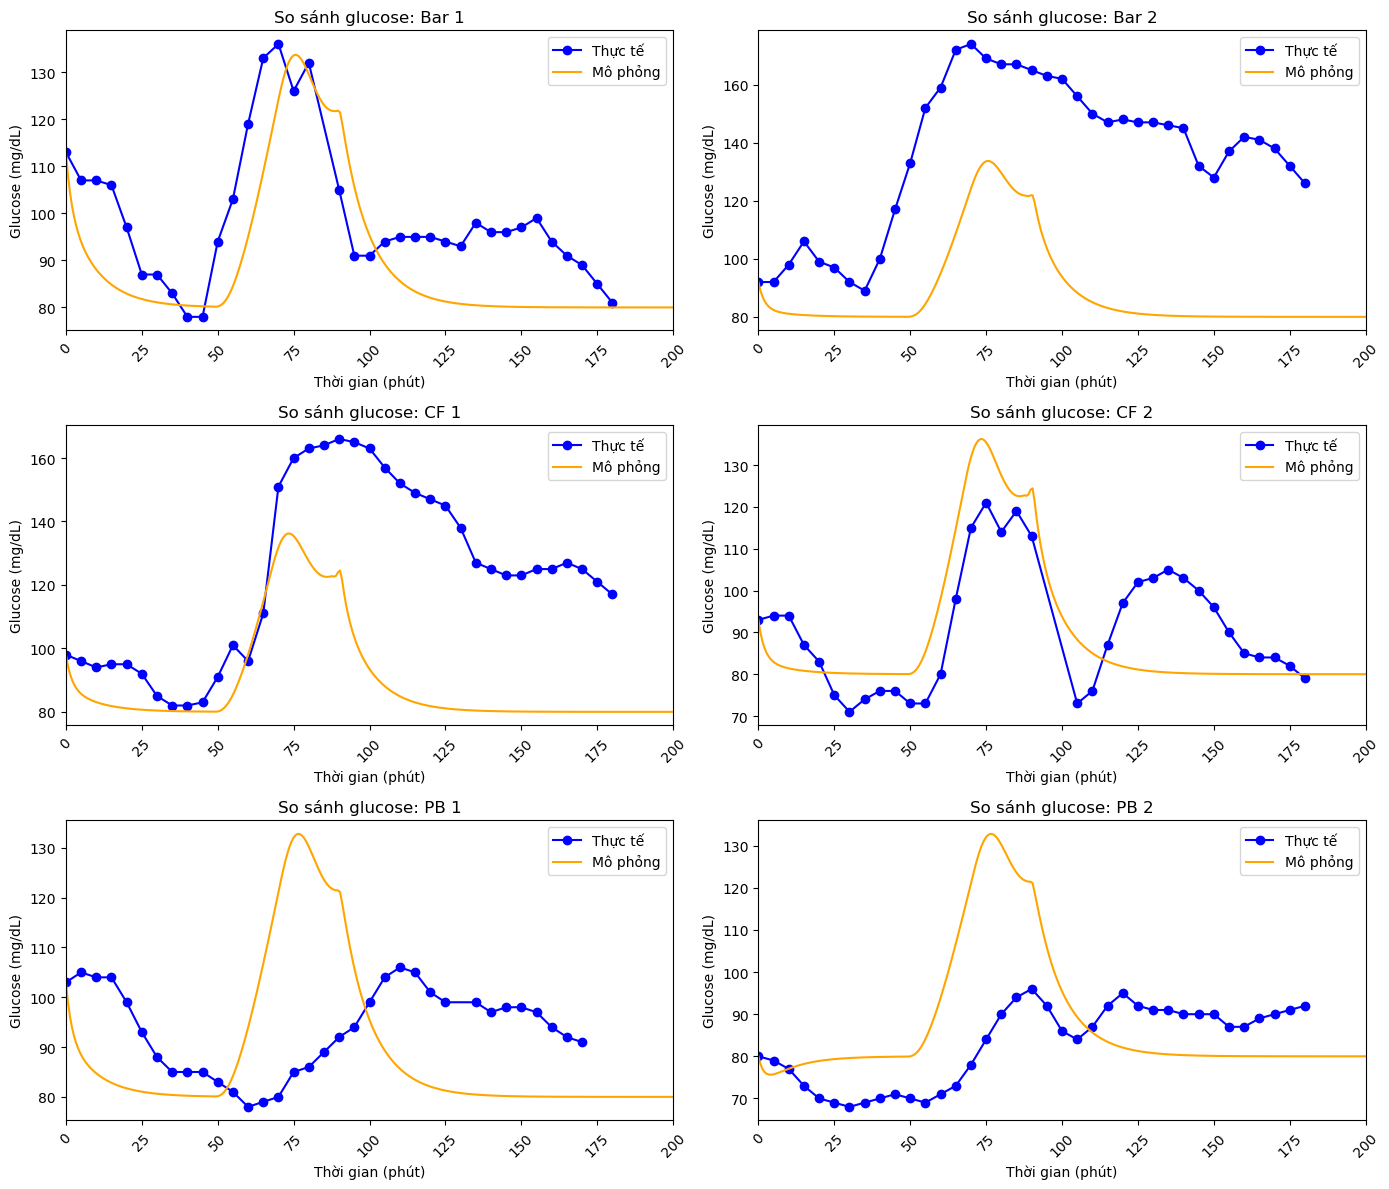

In [18]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('dataMMC - Sheet1.csv')

# Chuyển đổi cột 'time' thành định dạng datetime
data['time'] = pd.to_datetime(data['time'])

# Định nghĩa các giá trị G_food_max cho từng loại bữa ăn
G_food_max_values = {
    'Bar 1': 48 - 6,   # Lượng glucose tối đa từ Energy bar 1
    'Bar 2': 48 - 6,   # Lượng glucose tối đa từ Energy bar 2
    'CF 1': 54 - 3.3,   # Lượng glucose tối đa từ Cereal milk and raisins 1
    'CF 2': 54 - 3.3,   # Lượng glucose tối đa từ Cereal milk and raisins 2
    'PB 1': 51 - 12,    # Lượng glucose tối đa từ Bread and peanut butter 1
    'PB 2': 51 - 12    # Lượng glucose tối đa từ Bread and peanut butter 2
}

# Các tham số mô hình khác
alpha = 0.01  # Hệ số trong hàm sigmoid, ảnh hưởng đến tốc độ hấp thụ glucose ban đầu
beta = 0.6    # Hệ số giảm dần của glucose sau khi đạt đỉnh
gamma = 0.02  # Hệ số mượt mà hóa sự tăng ban đầu của glucose sau khi bắt đầu bữa ăn
t0 = 30 + 20  # Thời điểm bắt đầu tiêu thụ thức ăn (phút 30) 20 ở đây là quảng thời gian mà thức ăn đi vào dạ dày và bắt đầu tiêu hóa
t1 = 90       # Thời điểm bắt đầu giảm hấp thụ glucose sau khi đạt đỉnh (phút 80)

# Tham số liên quan đến glucose, insulin và glucagon
k1 = 0.1      # Tốc độ tiêu thụ glucose tự nhiên (nền) trong cơ thể
k2 = 0.005    # Tác động của insulin đến việc tiêu thụ glucose
k3 = 0.02     # Tác động của glucagon đến việc sản sinh glucose
i_g = 0.1     # Tốc độ sản xuất insulin khi glucose vượt ngưỡng (kích hoạt insulin)
i_b = 0.5     # Tốc độ phân hủy insulin khi glucose dưới ngưỡng (phân hủy insulin)
h_g = 0.3     # Tốc độ sản xuất glucagon khi glucose dưới ngưỡng thấp (kích hoạt glucagon)
h_b = 0.5     # Tốc độ phân hủy glucagon khi glucose vượt ngưỡng thấp (phân hủy glucagon)

# Các ngưỡng quan trọng
G_thresh = 120  # Ngưỡng glucose kích hoạt sản xuất insulin
G_low = 70      # Ngưỡng glucose kích hoạt sản xuất glucagon
G_b = 90        # Nồng độ glucose cơ bản mà cơ thể muốn giữ cân bằng (điểm cân bằng glucose)
H_b = 50        # Nồng độ glucagon cơ bản mà cơ thể muốn giữ cân bằng (điểm cân bằng glucagon)

# Hàm sigmoid mượt mà điều chỉnh mức glucose từ thức ăn theo thời gian
def G_food(t, G_max):
    if t < t0:
        return 0  # Trước khi bắt đầu ăn, lượng glucose từ thức ăn là 0
    elif t < t1:
        return G_max / (1 + np.exp(-alpha * (t - t0))) * (1 - np.exp(-gamma * (t - t0)))
        # Sau t0, lượng glucose tăng dần theo hàm sigmoid và được mượt mà hóa
    else:
        return (G_max / (1 + np.exp(-alpha * (t - t0))) * (1 - np.exp(-gamma * (t - t0)))) * np.exp(-beta * (t - t1))
        # Sau t1, lượng glucose giảm dần theo hàm mũ với hệ số beta

# Hệ phương trình vi phân mô tả sự biến thiên của glucose, insulin và glucagon
def model(t, y, G_max):
    G, I, H = y  # y chứa các giá trị của glucose (G), insulin (I) và glucagon (H) tại thời điểm t
    dG_dt = (G_food(t, G_max) - k1 * (G - G_b) - k2 * I * G + k3 * (H - H_b))
    # Phương trình vi phân của glucose:
    # dG_dt: tốc độ thay đổi của glucose theo thời gian
    # G_food(t, G_max): glucose từ thức ăn
    # k1 * (G - G_b): tiêu thụ glucose tự nhiên (đưa glucose về mức cân bằng G_b)
    # k2 * I * G: tiêu thụ glucose nhờ insulin
    # k3 * (H - H_b): sản xuất glucose nhờ glucagon
    
    # Phản ứng của insulin dựa trên nồng độ glucose
    if G > G_thresh:
        dI_dt = i_g * (G - G_thresh)  # Khi glucose vượt ngưỡng, insulin được sản xuất
    else:
        dI_dt = -i_b * I  # Khi glucose dưới ngưỡng, insulin bị phân hủy
    
    # Phản ứng của glucagon dựa trên nồng độ glucose
    if G < G_low:
        dH_dt = h_g * (G_low - G)  # Khi glucose dưới ngưỡng thấp, glucagon được sản xuất
    else:
        dH_dt = -h_b * H  # Khi glucose vượt ngưỡng thấp, glucagon bị phân hủy
    
    return [dG_dt, dI_dt, dH_dt]  # Trả về các tốc độ thay đổi của G, I và H

# Hàm mô phỏng glucose cho một loại bữa ăn cụ thể
def simulate_glucose(meal, G0, G_max):
    initial_conditions = [G0, I0, H0]  # Điều kiện ban đầu của glucose, insulin và glucagon
    sol = solve_ivp(model, [0, 200], initial_conditions, args=(G_max,), t_eval=np.linspace(0, 200, 300))
    return sol  # Trả về kết quả mô phỏng

# Khởi tạo các điều kiện ban đầu cho insulin và glucagon
I0 = 10  # Nồng độ insulin ban đầu
H0 = 30  # Nồng độ glucagon ban đầu

# Vẽ biểu đồ so sánh dự đoán mô hình với dữ liệu thực tế
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, meal in enumerate(G_food_max_values.keys()):
    # Lấy dữ liệu thực tế cho bữa ăn từ file CSV
    meal_data = data[data['Meal'] == meal]
    
    # Chuẩn hóa thời gian: thời gian tính từ thời điểm bắt đầu bữa ăn
    meal_data['minutes'] = (meal_data['time'] - meal_data['time'].min()).dt.total_seconds() / 60
    
    # Lấy dữ liệu trong khoảng từ 0 đến 200 phút
    meal_data = meal_data[meal_data['minutes'] <= 200]
    
    actual_times = meal_data['minutes']  # Thời gian thực tế
    actual_glucose = meal_data['GlucoseValue']  # Nồng độ glucose thực tế
    
    # Lấy giá trị glucose ban đầu từ dữ liệu thực tế
    G0 = actual_glucose.iloc[0]
    
    # Chạy mô hình với giá trị glucose ban đầu và lượng glucose từ thức ăn
    G_max = G_food_max_values[meal]
    sol = simulate_glucose(meal, G0, G_max)
    
    # Trích xuất kết quả mô phỏng từ mô hình
    sim_times = sol.t
    sim_glucose = sol.y[0]
    
    # Vẽ biểu đồ so sánh glucose thực tế và mô phỏng
    axes[i].plot(actual_times, actual_glucose, label='Thực tế', marker='o', color='blue')
    axes[i].plot(sim_times, sim_glucose, label='Mô phỏng', color='orange')
    axes[i].set_xlim(0, 200)  # Giới hạn trục x từ 0 đến 200 phút
    axes[i].set_title(f'So sánh glucose: {meal}')
    axes[i].set_xlabel('Thời gian (phút)')
    axes[i].set_ylabel('Glucose (mg/dL)')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

plt.savefig('AccuracyOfModel_Same_Parameter')
plt.tight_layout()
plt.show()


## II/ Tối Ưu Tham Số Cho Từng Loại Thực Phẩm
Dựa trên thông tin dinh dưỡng đã cung cấp, ta sẽ xác định các tham số của hàm sigmoid cho các loại đồ ăn (PB, Bar, CF) bằng cách ước tính từ các dữ liệu dinh dưỡng như carbohydrate, đường và năng lượng (calories).

1. **$G_{\text{max}}$** (lượng glucose tối đa từ thức ăn):
   - Carbohydrates là nguồn chính cho glucose. Ta sẽ sử dụng tổng lượng carbohydrates, đặc biệt là đường, vì đường là thành phần được hấp thụ nhanh chóng thành glucose.
   - Ta sẽ ước lượng $G_{\text{max}}$ dựa trên carbohydrate và đường, với giả định rằng lượng glucose tối đa phụ thuộc vào lượng carbohydrates tiêu thụ.

2. **$\alpha$** (hệ số độ dốc của hàm sigmoid):
   - $\alpha$ sẽ phụ thuộc vào hàm lượng chất xơ và chất béo. Chất xơ làm giảm tốc độ hấp thụ glucose, trong khi chất béo có thể làm chậm quá trình tiêu hóa và hấp thụ.

3. **$\beta$** (tốc độ giảm hấp thụ glucose):
   - $\beta$ sẽ phụ thuộc vào protein và chất béo, do chúng ảnh hưởng đến quá trình tiêu hóa lâu dài và kéo dài thời gian giảm dần lượng glucose.

### Cách tính tham số:
- **$G_{\text{max}}$:**
  - Sử dụng lượng carbohydrates (g) làm chỉ số chính cho $G_{\text{max}}$.
  - Điều chỉnh dựa trên đường (vì đường được hấp thụ nhanh hơn) để phản ánh mức tăng glucose.
  
- **$\alpha$:**
  - Sử dụng chất xơ để điều chỉnh độ dốc của hàm sigmoid, vì chất xơ làm chậm hấp thụ glucose. Hàm lượng chất béo cũng được sử dụng để điều chỉnh tốc độ tăng glucose.

- **$\beta$:**
  - Sử dụng lượng protein và chất béo để điều chỉnh tốc độ giảm glucose, vì chúng kéo dài quá trình tiêu hóa.

### Ước tính tham số cho từng loại đồ ăn:
#### 1. Bread and Peanut Butter (PB):
- Carbohydrates: 51g (trong đó đường: 12g)
- $G_{\text{max}} \approx 51$
- $\alpha$: Phụ thuộc vào chất xơ (12g) và chất béo (20g), $\alpha \approx 0.025$
- $\beta$: Phụ thuộc vào protein (18g) và chất béo (20g), $\beta \approx 0.015$

#### 2. Energy Bar (Bar):
- Carbohydrates: 48g (trong đó đường: 19g)
- $G_{\text{max}} \approx 48$
- $\alpha$: Phụ thuộc vào chất xơ (6g) và chất béo (18g), $\alpha \approx 0.01$
- $\beta$: Phụ thuộc vào protein (9g) và chất béo (18g), $\beta \approx 0.6$
#### 3. Cereal Milk and Raisins (CF):
- Carbohydrates: 54g (trong đó đường: 35.2g)
- $G_{\text{max}} \approx 54$
- $\alpha$: Phụ thuộc vào chất xơ (3.3g) và chất béo (2.5g), $\alpha \approx 0.04$
- $\beta$: Phụ thuộc vào protein (11g) và chất béo (2.5g), $\beta \approx 0.2$

### Tham số tổng quát cho các loại đồ ăn:

| Loại đồ ăn            | $G_{\text{max}}$ | $\alpha$ | $\beta$ |
|-----------------------|------------------|----------|---------|
| Bread and Peanut Butter (PB) | 51               | 0.025    | 0.15   |
| Energy Bar (Bar)              | 48               | 0.03     | 0.6    |
| Cereal Milk and Raisins (CF)  | 54               | 0.04     | 0.2    |


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7644\3691662015.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meal_data['minutes'] = (meal_data['time'] - meal_data['time'].min()).dt.total_seconds() / 60
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7644\3691662015.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meal_data['minutes'] = (meal_data['time'] - meal_data['time'].min()).dt.total_seconds() / 60
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7644\3691662015.py:102: SettingWithCopyWarning: 
A val

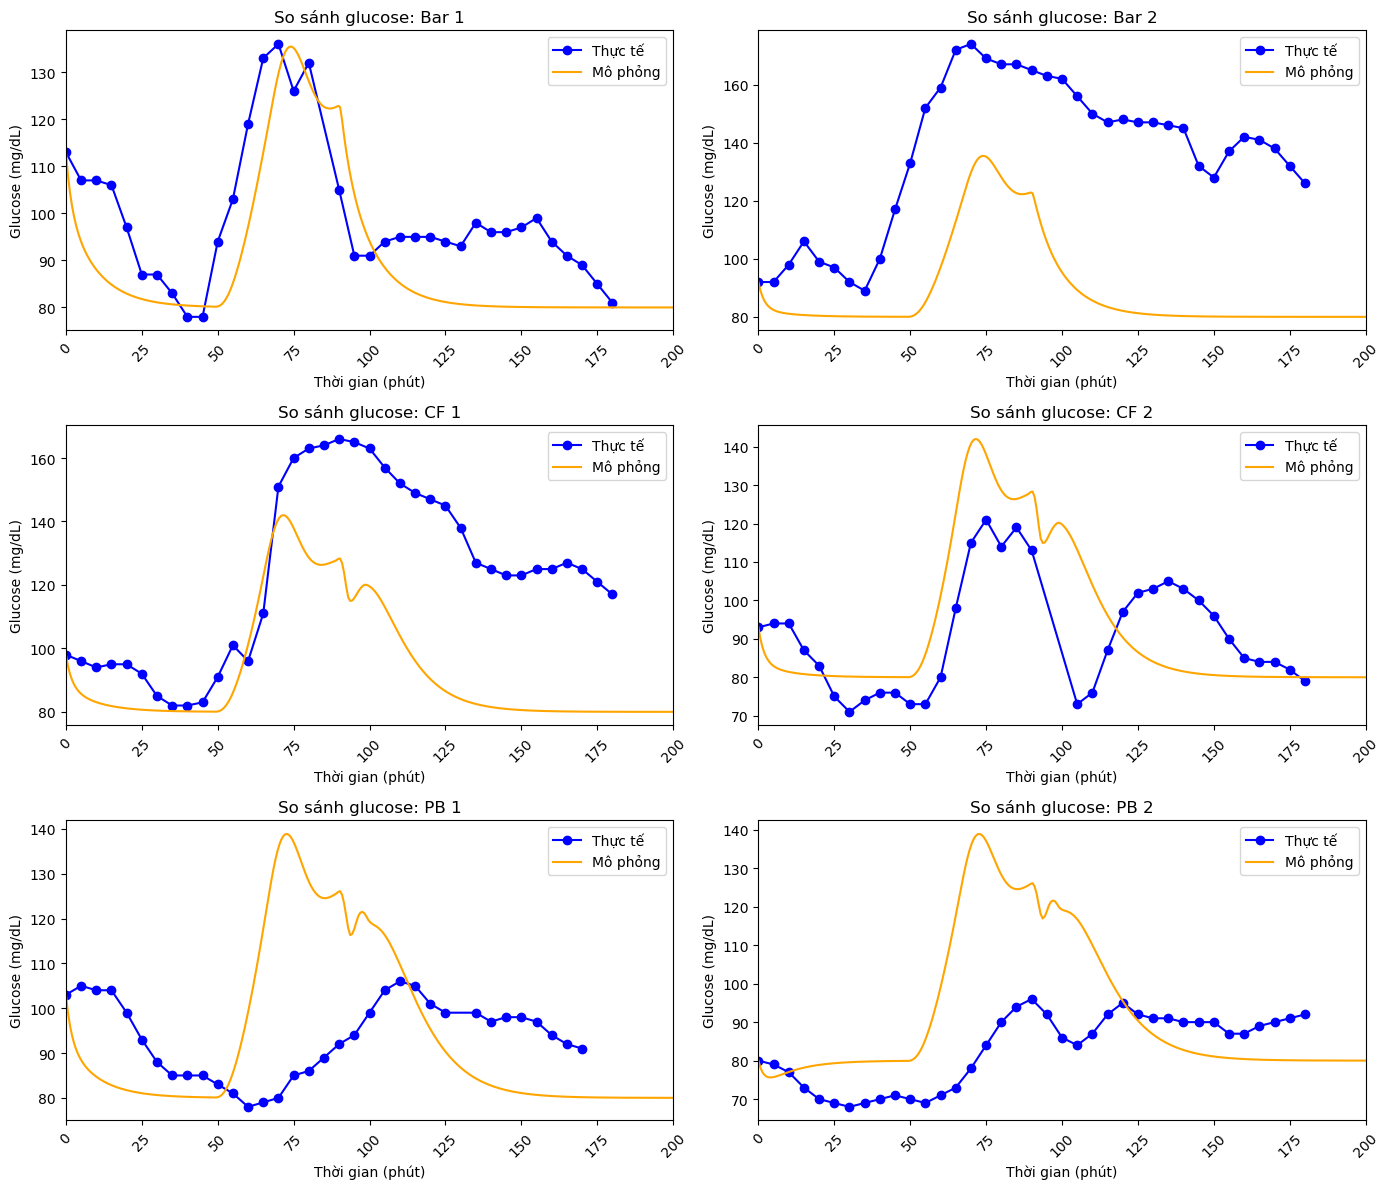

In [19]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('dataMMC - Sheet1.csv')

# Chuyển đổi cột 'time' thành định dạng datetime
data['time'] = pd.to_datetime(data['time'])

# Định nghĩa các giá trị G_food_max và các tham số alpha, beta cho từng loại bữa ăn
meal_params = {
    'Bar 1': {'G_max': 48, 'alpha': 0.01, 'beta': 0.6},
    'Bar 2': {'G_max': 48, 'alpha': 0.01, 'beta': 0.6},
    'CF 1': {'G_max': 54, 'alpha': 0.04, 'beta': 0.2},
    'CF 2': {'G_max': 54, 'alpha': 0.04, 'beta': 0.2},
    'PB 1': {'G_max': 51, 'alpha': 0.025, 'beta': 0.15},
    'PB 2': {'G_max': 51, 'alpha': 0.025, 'beta': 0.15}
}

# Các tham số mô hình khác
gamma = 0.02  # Hệ số mượt mà hóa sự tăng ban đầu của glucose sau khi bắt đầu bữa ăn
t0 = 30 + 20  # Thời điểm bắt đầu tiêu thụ thức ăn (phút 30) 20 ở đây là quảng thời gian mà thức ăn đi vào dạ dày và bắt đầu tiêu hóa
t1 = 90       # Thời điểm bắt đầu giảm hấp thụ glucose sau khi đạt đỉnh (phút 80)

# Tham số liên quan đến glucose, insulin và glucagon
k1 = 0.1     # Tốc độ tiêu thụ glucose tự nhiên (nền) trong cơ thể
k2 = 0.005     # Tác động của insulin đến việc tiêu thụ glucose
k3 = 0.02     # Tác động của glucagon đến việc sản sinh glucose
i_g = 0.1     # Tốc độ sản xuất insulin khi glucose vượt ngưỡng (kích hoạt insulin)
i_b = 0.5     # Tốc độ phân hủy insulin khi glucose dưới ngưỡng (phân hủy insulin)
h_g = 0.3     # Tốc độ sản xuất glucagon khi glucose dưới ngưỡng thấp (kích hoạt glucagon)
h_b = 0.5     # Tốc độ phân hủy glucagon khi glucose vượt ngưỡng thấp (phân hủy glucagon)

# Các ngưỡng quan trọng
G_thresh = 120  # Ngưỡng glucose kích hoạt sản xuất insulin
G_low = 70      # Ngưỡng glucose kích hoạt sản xuất glucagon
G_b = 90        # Nồng độ glucose cơ bản mà cơ thể muốn giữ cân bằng (điểm cân bằng glucose)
H_b = 50        # Nồng độ glucagon cơ bản mà cơ thể muốn giữ cân bằng (điểm cân bằng glucagon)

# Hàm sigmoid mượt mà điều chỉnh mức glucose từ thức ăn theo thời gian
def G_food(t, G_max, alpha, beta):
    if t < t0:
        return 0  # Trước khi bắt đầu ăn, lượng glucose từ thức ăn là 0
    elif t < t1:
        return G_max / (1 + np.exp(-alpha * (t - t0))) * (1 - np.exp(-gamma * (t - t0)))
        # Sau t0, lượng glucose tăng dần theo hàm sigmoid và được mượt mà hóa
    else:
        return (G_max / (1 + np.exp(-alpha * (t - t0))) * (1 - np.exp(-gamma * (t - t0)))) * np.exp(-beta * (t - t1))
        # Sau t1, lượng glucose giảm dần theo hàm mũ với hệ số beta

# Hệ phương trình vi phân mô tả sự biến thiên của glucose, insulin và glucagon
def model(t, y, G_max, alpha, beta):
    G, I, H = y  # y chứa các giá trị của glucose (G), insulin (I) và glucagon (H) tại thời điểm t
    dG_dt = (G_food(t, G_max, alpha, beta) - k1 * (G - G_b) - k2 * I * G + k3 * (H - H_b))
    # Phương trình vi phân của glucose:
    # dG_dt: tốc độ thay đổi của glucose theo thời gian
    # G_food(t, G_max, alpha, beta): glucose từ thức ăn
    # k1 * (G - G_b): tiêu thụ glucose tự nhiên (đưa glucose về mức cân bằng G_b)
    # k2 * I * G: tiêu thụ glucose nhờ insulin
    # k3 * (H - H_b): sản xuất glucose nhờ glucagon
    
    # Phản ứng của insulin dựa trên nồng độ glucose
    if G > G_thresh:
        dI_dt = i_g * (G - G_thresh)  # Khi glucose vượt ngưỡng, insulin được sản xuất
    else:
        dI_dt = -i_b * I  # Khi glucose dưới ngưỡng, insulin bị phân hủy
    
    # Phản ứng của glucagon dựa trên nồng độ glucose
    if G < G_low:
        dH_dt = h_g * (G_low - G)  # Khi glucose dưới ngưỡng thấp, glucagon được sản xuất
    else:
        dH_dt = -h_b * H  # Khi glucose vượt ngưỡng thấp, glucagon bị phân hủy
    
    return [dG_dt, dI_dt, dH_dt]  # Trả về các tốc độ thay đổi của G, I và H

# Hàm mô phỏng glucose cho một loại bữa ăn cụ thể
def simulate_glucose(meal, G0):
    params = meal_params[meal]
    G_max = params['G_max']
    alpha = params['alpha']
    beta = params['beta']
    
    initial_conditions = [G0, I0, H0]  # Điều kiện ban đầu của glucose, insulin và glucagon
    sol = solve_ivp(model, [0, 200], initial_conditions, args=(G_max, alpha, beta), t_eval=np.linspace(0, 200, 300))
    return sol  # Trả về kết quả mô phỏng

# Khởi tạo các điều kiện ban đầu cho insulin và glucagon
I0 = 10  # Nồng độ insulin ban đầu
H0 = 30  # Nồng độ glucagon ban đầu

# Vẽ biểu đồ so sánh dự đoán mô hình với dữ liệu thực tế
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, meal in enumerate(meal_params.keys()):
    # Lấy dữ liệu thực tế cho bữa ăn từ file CSV
    meal_data = data[data['Meal'] == meal]
    
    # Chuẩn hóa thời gian: thời gian tính từ thời điểm bắt đầu bữa ăn
    meal_data['minutes'] = (meal_data['time'] - meal_data['time'].min()).dt.total_seconds() / 60
    
    # Lấy dữ liệu trong khoảng từ 0 đến 200 phút
    meal_data = meal_data[meal_data['minutes'] <= 200]
    
    actual_times = meal_data['minutes']  # Thời gian thực tế
    actual_glucose = meal_data['GlucoseValue']  # Nồng độ glucose thực tế
    
    # Lấy giá trị glucose ban đầu từ dữ liệu thực tế
    G0 = actual_glucose.iloc[0]
    
    # Chạy mô hình với giá trị glucose ban đầu và lượng glucose từ thức ăn
    sol = simulate_glucose(meal, G0)
    
    # Trích xuất kết quả mô phỏng từ mô hình
    sim_times = sol.t
    sim_glucose = sol.y[0]
    
    # Vẽ biểu đồ so sánh glucose thực tế và mô phỏng
    axes[i].plot(actual_times, actual_glucose, label='Thực tế', marker='o', color='blue')
    axes[i].plot(sim_times, sim_glucose, label='Mô phỏng', color='orange')
    axes[i].set_xlim(0, 200)  # Giới hạn trục x từ 0 đến 200 phút
    axes[i].set_title(f'So sánh glucose: {meal}')
    axes[i].set_xlabel('Thời gian (phút)')
    axes[i].set_ylabel('Glucose (mg/dL)')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

plt.savefig('AccuracyOfModel_Different_Parameter')
plt.tight_layout()
plt.show()
